In [1]:
from keras import optimizers
from keras.models import Model
from keras.preprocessing import image
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.layer_utils import print_summary
from keras.deeplearningmodels.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from keras.deeplearningmodels.inception_resnet_v2 import InceptionResNetV2
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from sklearn import cross_validation

import os, sys

import h5py

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline


Using TensorFlow backend.
/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

# Create the model
base_model = InceptionResNetV2(include_top=False, weights=None)
model_name = 'InceptionResNetV2'

#base_model = ResNet50(include_top=False, weights=None)
#model_name = 'ResNet50'

#base_model = resnet152_model()
#model_name = 'ResNet152'

#base_model = Xception(include_top=False, weights=None)
#model_name = 'Xception'

#print_summary(base_model)

In [9]:

# If directory exist
def check_dir(path):
    if os.path.exists(path):
        print("Dir already existing")
    
    elif sys.platform == 'win32':
        os.system('mkdir ' + path)
    
    else:
        os.system('mkdir -p ' + path)
        print('New Path created : ', path)
    return 
    

In [10]:
# Set root to dataset location
root = './dataset/Cropped_BM3D/Experiment_' + model_name
check_dir(root)
print('current root folder : ', root)


Dir already existing
current root folder :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2


In [5]:
# Define the routine the add a new last layer
def add_new_last_layer(base_model, nb_classes):
 
    print('Add last layer to the convnet..')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(nb_classes, activation='relu')(x)  # new FC layer, random init
    predictions = Dense(nb_classes, activation='softmax')(x)  # new softmax layer
    model = Model(inputs=base_model.input, outputs=predictions)  # Combine the network
    
    """
    from keras.models import Model
    >> The `Model` class adds training & evaluation routines to a `Container`.
    """
    return model


In [6]:


# Add the new last layer to the model 
nb_classes = 2
model = add_new_last_layer(base_model, nb_classes)

learning_rate = 0.0001
decay_rate = learning_rate / 100
momentum = 0.8
# SGD = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
SGD = optimizers.SGD(lr=learning_rate)

model.compile(optimizer=RMSprop(lr=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print_summary(model)

Add last layer to the convnet..
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________

                                                                   activation_132[0][0]             
____________________________________________________________________________________________________
block17_14_conv (Conv2D)         (None, None, None, 10 418880      block17_14_mixed[0][0]           
____________________________________________________________________________________________________
block17_14 (Lambda)              (None, None, None, 10 0           block17_13_ac[0][0]              
                                                                   block17_14_conv[0][0]            
____________________________________________________________________________________________________
block17_14_ac (Activation)       (None, None, None, 10 0           block17_14[0][0]                 
____________________________________________________________________________________________________
conv2d_134 (Conv2D)              (None, None, None, 12 139264      block17_14_ac[0][0]     

In [12]:
# Save the random weight
# model1.load_weights(path) #If you have pretrained weights
path = root + '/weight/'
print('root: ', root)
print('model name: ', model_name)

check_dir(path)

path = path + model_name + '_rndm_weight.h5'
print('path: ', path)
model.save_weights(path)  # If you want to save random weights


root:  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2
model name:  InceptionResNetV2
Dir already existing
path:  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/weight/InceptionResNetV2_rndm_weight.h5


In [13]:
# Load the data
hdf5_path = './dataset/Cropped_BM3D/hdf5_file/Cropped_BM3D_4.hdf5'

h5f = h5py.File(hdf5_path, 'r')

input_img = h5f['img'][:]
input_labels = h5f['labels_OHE'][:]

h5f.close()

In [14]:
# Set Parameters of OCT-NET
batch_size = int(16)
nb_epochs = int(20)


Dir already existing
Training and Testing on the OCT Volume no:  1
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/checkpoint/
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_1
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_csv/


/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel_launcher.py:87: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 94s - loss: 0.4396 - acc: 0.9181 - val_loss: 6.4516 - val_acc: 0.1484
Epoch 2/20
3968/3968 [==============================] - 90s - loss: 0.3677 - acc: 0.9672 - val_loss: 0.6497 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3334 - acc: 0.9826 - val_loss: 3.0020 - val_acc: 0.4688
Epoch 4/20
3968/3968 [==============================] - 88s - loss: 0.3196 - acc: 0.9849 - val_loss: 0.6167 - val_acc: 0.9922
Epoch 5/20
3968/3968 [==============================] - 88s - loss: 0.3041 - acc: 0.9889 - val_loss: 0.5910 - val_acc: 0.9922
Epoch 6/20
3968/3968 [==============================] - 88s - loss: 0.2978 - acc: 0.9884 - val_loss: 1.2556 - val_acc: 0.7969
Epoch 7/20
3968/3968 [==============================] - 88s - loss: 0.2786 - acc: 0.9919 - val_loss: 1.2938 - val_acc: 0.7500
Epoch 8/20
3968/3968 [==============================] - 88s - loss: 0.2

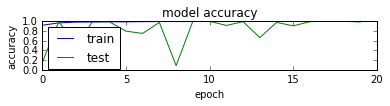

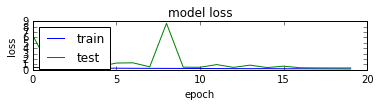

acc: 98.44%
Training and Testing on the OCT Volume no:  2
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_2
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4296 - acc: 0.9317 - val_loss: 6.1251 - val_acc: 0.0312
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3675 - acc: 0.9672 - val_loss: 5.4318 - val_acc: 0.2500
Epoch 3/20
3968/3968 [==============================] - 91s - loss: 0.3320 - acc: 0.9821 - val_loss: 0.6267 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3176 - acc: 0.9839 - val_loss: 0.6051 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3059 - acc: 0.9899 - val_loss: 0.7233 - val_acc: 0.8906
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2923 -

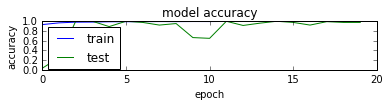

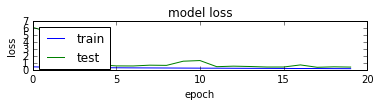

acc: 97.66%
Training and Testing on the OCT Volume no:  3
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_3
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4263 - acc: 0.9244 - val_loss: 8.6392 - val_acc: 0.0000e+00
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3663 - acc: 0.9647 - val_loss: 3.1448 - val_acc: 0.4766
Epoch 3/20
3968/3968 [==============================] - 90s - loss: 0.3533 - acc: 0.9740 - val_loss: 0.7743 - val_acc: 0.9297
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3245 - acc: 0.9849 - val_loss: 5.8447 - val_acc: 0.1406
Epoch 5/20
3968/3968 [==============================] - 91s - loss: 0.3050 - acc: 0.9889 - val_loss: 0.5846 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.29

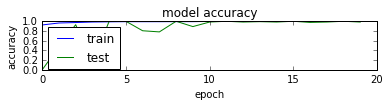

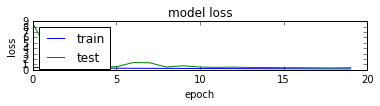

acc: 98.44%
Training and Testing on the OCT Volume no:  4
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_4
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4332 - acc: 0.9216 - val_loss: 12.0415 - val_acc: 0.0000e+00
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3645 - acc: 0.9650 - val_loss: 0.6492 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3382 - acc: 0.9824 - val_loss: 0.6636 - val_acc: 0.9688
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3230 - acc: 0.9871 - val_loss: 0.7618 - val_acc: 0.9141
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.2986 - acc: 0.9922 - val_loss: 0.5839 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2

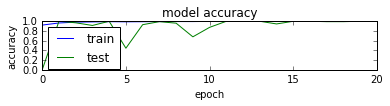

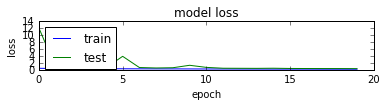

acc: 100.00%
Training and Testing on the OCT Volume no:  5
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_5
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4398 - acc: 0.9156 - val_loss: 5.3179 - val_acc: 0.1250
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3659 - acc: 0.9682 - val_loss: 0.9804 - val_acc: 0.8594
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3414 - acc: 0.9768 - val_loss: 5.2399 - val_acc: 0.1094
Epoch 4/20
3968/3968 [==============================] - 90s - loss: 0.3241 - acc: 0.9844 - val_loss: 0.6225 - val_acc: 0.9922
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3034 - acc: 0.9904 - val_loss: 0.7146 - val_acc: 0.9453
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2930 

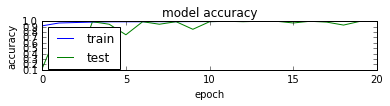

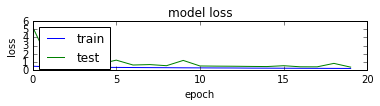

acc: 100.00%
Training and Testing on the OCT Volume no:  6
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_6
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4237 - acc: 0.9189 - val_loss: 8.4103 - val_acc: 0.0781
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3695 - acc: 0.9670 - val_loss: 0.6493 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3339 - acc: 0.9829 - val_loss: 2.2117 - val_acc: 0.6094
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3170 - acc: 0.9874 - val_loss: 0.6052 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3098 - acc: 0.9871 - val_loss: 1.7980 - val_acc: 0.7500
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2945 

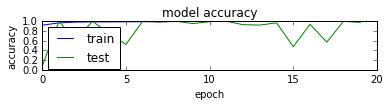

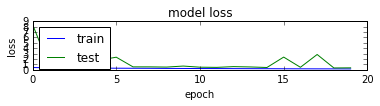

acc: 97.66%
Training and Testing on the OCT Volume no:  7
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_7
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4240 - acc: 0.9289 - val_loss: 7.9718 - val_acc: 0.0938
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3651 - acc: 0.9682 - val_loss: 0.7107 - val_acc: 0.9609
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3396 - acc: 0.9801 - val_loss: 5.0945 - val_acc: 0.5781
Epoch 4/20
3968/3968 [==============================] - 91s - loss: 0.3252 - acc: 0.9841 - val_loss: 0.6428 - val_acc: 0.9844
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3128 - acc: 0.9861 - val_loss: 1.7242 - val_acc: 0.7031
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2927 -

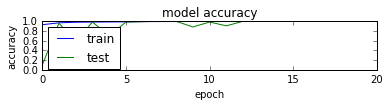

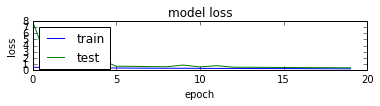

acc: 100.00%
Training and Testing on the OCT Volume no:  8
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_8
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4360 - acc: 0.9168 - val_loss: 4.3116 - val_acc: 0.3438
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3693 - acc: 0.9667 - val_loss: 1.1545 - val_acc: 0.7031
Epoch 3/20
3968/3968 [==============================] - 90s - loss: 0.3460 - acc: 0.9753 - val_loss: 0.6271 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3186 - acc: 0.9806 - val_loss: 0.6053 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3126 - acc: 0.9854 - val_loss: 2.3249 - val_acc: 0.5391
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2941 

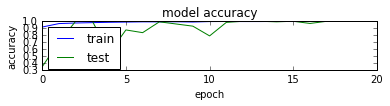

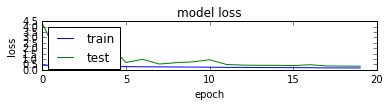

acc: 100.00%
Training and Testing on the OCT Volume no:  9
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_9
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4261 - acc: 0.9226 - val_loss: 8.7176 - val_acc: 0.1875
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3707 - acc: 0.9680 - val_loss: 2.5219 - val_acc: 0.4141
Epoch 3/20
3968/3968 [==============================] - 91s - loss: 0.3498 - acc: 0.9778 - val_loss: 0.6269 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3252 - acc: 0.9819 - val_loss: 0.6057 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3061 - acc: 0.9889 - val_loss: 0.5958 - val_acc: 0.9766
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2928 

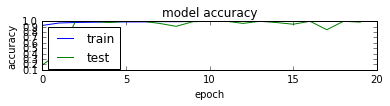

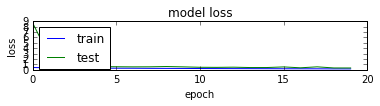

acc: 98.44%
Training and Testing on the OCT Volume no:  10
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_10
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4166 - acc: 0.9322 - val_loss: 13.2781 - val_acc: 0.0312
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3716 - acc: 0.9662 - val_loss: 0.8796 - val_acc: 0.8984
Epoch 3/20
3968/3968 [==============================] - 91s - loss: 0.3355 - acc: 0.9814 - val_loss: 0.6764 - val_acc: 0.9609
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3181 - acc: 0.9859 - val_loss: 13.3657 - val_acc: 0.0156
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3053 - acc: 0.9877 - val_loss: 0.6078 - val_acc: 0.9609
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.29

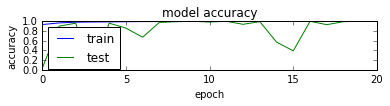

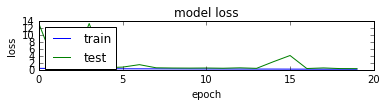

acc: 100.00%
Training and Testing on the OCT Volume no:  11
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_11
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4189 - acc: 0.9312 - val_loss: 12.7368 - val_acc: 0.0000e+00
Epoch 2/20
3968/3968 [==============================] - 90s - loss: 0.3629 - acc: 0.9695 - val_loss: 0.6974 - val_acc: 0.9531
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3409 - acc: 0.9776 - val_loss: 2.5696 - val_acc: 0.5938
Epoch 4/20
3968/3968 [==============================] - 91s - loss: 0.3233 - acc: 0.9882 - val_loss: 0.6054 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3036 - acc: 0.9899 - val_loss: 1.5042 - val_acc: 0.7578
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 

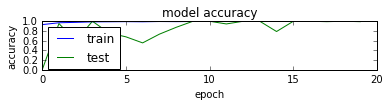

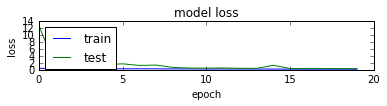

acc: 99.22%
Training and Testing on the OCT Volume no:  12
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_12
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4349 - acc: 0.9191 - val_loss: 6.9960 - val_acc: 0.0312
Epoch 2/20
3968/3968 [==============================] - 90s - loss: 0.3664 - acc: 0.9720 - val_loss: 3.2787 - val_acc: 0.4609
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3359 - acc: 0.9793 - val_loss: 3.3436 - val_acc: 0.2734
Epoch 4/20
3968/3968 [==============================] - 91s - loss: 0.3189 - acc: 0.9864 - val_loss: 2.3952 - val_acc: 0.5469
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3078 - acc: 0.9899 - val_loss: 6.7488 - val_acc: 0.0234
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2871

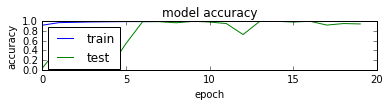

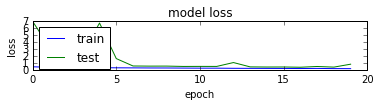

acc: 94.53%
Training and Testing on the OCT Volume no:  13
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_13
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4304 - acc: 0.9229 - val_loss: 8.3131 - val_acc: 0.0234
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3695 - acc: 0.9627 - val_loss: 0.8924 - val_acc: 0.8828
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3377 - acc: 0.9801 - val_loss: 2.5570 - val_acc: 0.4062
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3204 - acc: 0.9854 - val_loss: 0.8296 - val_acc: 0.8359
Epoch 5/20
3968/3968 [==============================] - 91s - loss: 0.3043 - acc: 0.9899 - val_loss: 0.6214 - val_acc: 0.9922
Epoch 6/20
3968/3968 [==============================] - 90s - loss: 0.2966

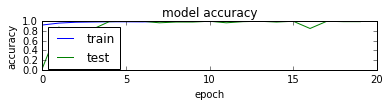

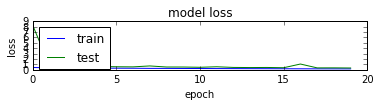

acc: 99.22%
Training and Testing on the OCT Volume no:  14
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_14
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4309 - acc: 0.9337 - val_loss: 7.1387 - val_acc: 0.0938
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3691 - acc: 0.9662 - val_loss: 0.6656 - val_acc: 0.9922
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3365 - acc: 0.9791 - val_loss: 1.3415 - val_acc: 0.7188
Epoch 4/20
3968/3968 [==============================] - 91s - loss: 0.3309 - acc: 0.9831 - val_loss: 0.6050 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3079 - acc: 0.9887 - val_loss: 0.6829 - val_acc: 0.9375
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.2925

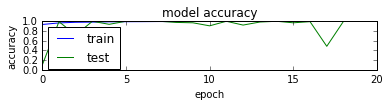

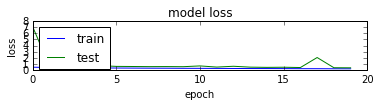

acc: 100.00%
Training and Testing on the OCT Volume no:  15
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_15
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4298 - acc: 0.9226 - val_loss: 8.0455 - val_acc: 0.1484
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3627 - acc: 0.9677 - val_loss: 1.3311 - val_acc: 0.8125
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3549 - acc: 0.9766 - val_loss: 3.2757 - val_acc: 0.3281
Epoch 4/20
3968/3968 [==============================] - 91s - loss: 0.3119 - acc: 0.9892 - val_loss: 0.6950 - val_acc: 0.9453
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3030 - acc: 0.9909 - val_loss: 14.6218 - val_acc: 0.0078
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.29

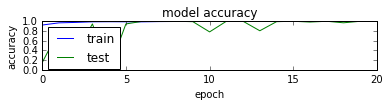

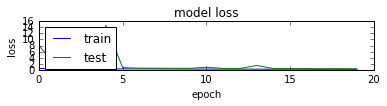

acc: 100.00%
Training and Testing on the OCT Volume no:  16
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_16
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4299 - acc: 0.9226 - val_loss: 2.2795 - val_acc: 0.6250
Epoch 2/20
3968/3968 [==============================] - 91s - loss: 0.3603 - acc: 0.9672 - val_loss: 1.2478 - val_acc: 0.9141
Epoch 3/20
3968/3968 [==============================] - 91s - loss: 0.3473 - acc: 0.9718 - val_loss: 0.6893 - val_acc: 0.9609
Epoch 4/20
3968/3968 [==============================] - 91s - loss: 0.3290 - acc: 0.9811 - val_loss: 0.6533 - val_acc: 0.9688
Epoch 5/20
3968/3968 [==============================] - 91s - loss: 0.3104 - acc: 0.9854 - val_loss: 0.5884 - val_acc: 0.9922
Epoch 6/20
3968/3968 [==============================] - 87s - loss: 0.294

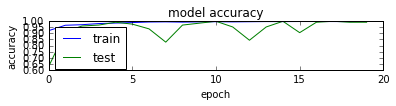

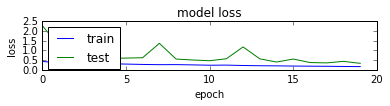

acc: 99.22%
Training and Testing on the OCT Volume no:  17
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_17
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4523 - acc: 0.9254 - val_loss: 2.1635e-06 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3866 - acc: 0.9647 - val_loss: 6.1973e-05 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3641 - acc: 0.9791 - val_loss: 1.3270e-05 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3499 - acc: 0.9811 - val_loss: 2.1027e-05 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3175 - acc: 0.9917 - val_loss: 8.5559e-05 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] 

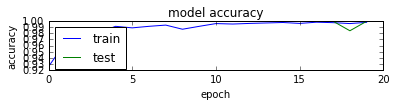

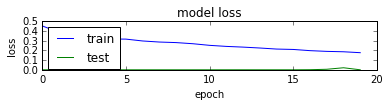

acc: 100.00%
Training and Testing on the OCT Volume no:  18
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_18
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4446 - acc: 0.9274 - val_loss: 1.3225e-07 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3932 - acc: 0.9584 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3623 - acc: 0.9756 - val_loss: 0.0368 - val_acc: 0.9609
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3433 - acc: 0.9859 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3298 - acc: 0.9839 - val_loss: 0.1226 - val_acc: 0.8828
Epoch 6/20
3968/3968 [==============================] - 87s -

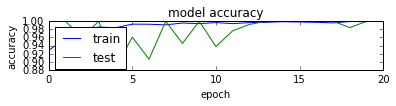

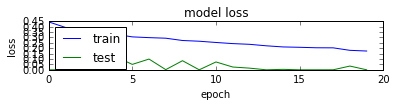

acc: 100.00%
Training and Testing on the OCT Volume no:  19
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_19
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4544 - acc: 0.9211 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.4002 - acc: 0.9607 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3584 - acc: 0.9791 - val_loss: 0.0115 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3360 - acc: 0.9882 - val_loss: 0.0255 - val_acc: 0.9688
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3240 - acc: 0.9889 - val_loss: 0.0364 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 87s - los

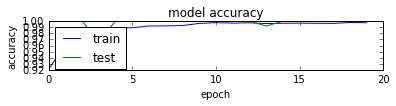

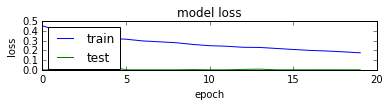

acc: 100.00%
Training and Testing on the OCT Volume no:  20
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_20
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 88s - loss: 0.4499 - acc: 0.9201 - val_loss: 2.2631e-04 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3841 - acc: 0.9688 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3614 - acc: 0.9766 - val_loss: 0.0345 - val_acc: 0.9766
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3440 - acc: 0.9856 - val_loss: 2.2980e-04 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3200 - acc: 0.9907 - val_loss: 0.0206 - val_acc: 0.9844
Epoch 6/20
3968/3968 [==============================] - 87s -

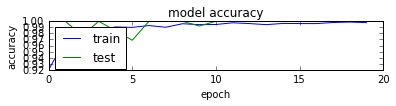

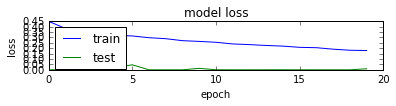

acc: 100.00%
Training and Testing on the OCT Volume no:  21
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_21
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4593 - acc: 0.9178 - val_loss: 2.0268e-04 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3903 - acc: 0.9614 - val_loss: 0.0084 - val_acc: 0.9922
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3698 - acc: 0.9740 - val_loss: 4.1787e-05 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3444 - acc: 0.9826 - val_loss: 0.0382 - val_acc: 0.9766
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3302 - acc: 0.9877 - val_loss: 0.0139 - val_acc: 0.9844
Epoch 6/20
3968/3968 [==============================] - 87s - los

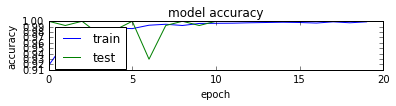

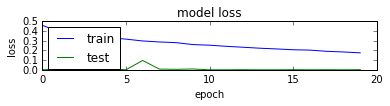

acc: 100.00%
Training and Testing on the OCT Volume no:  22
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_22
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4494 - acc: 0.9269 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3939 - acc: 0.9627 - val_loss: 1.5032e-06 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3587 - acc: 0.9801 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3422 - acc: 0.9824 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3260 - acc: 0.9879 - val_loss: 1.5832e-07 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 8

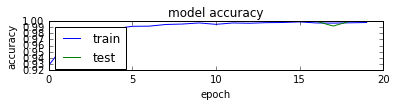

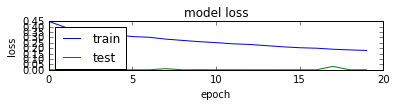

acc: 100.00%
Training and Testing on the OCT Volume no:  23
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_23
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4523 - acc: 0.9264 - val_loss: 4.6007e-07 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3834 - acc: 0.9652 - val_loss: 0.0260 - val_acc: 0.9766
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3727 - acc: 0.9730 - val_loss: 4.6415e-05 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3407 - acc: 0.9816 - val_loss: 3.0128e-07 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3316 - acc: 0.9874 - val_loss: 0.0112 - val_acc: 0.9922
Epoch 6/20
3968/3968 [==============================] - 87s -

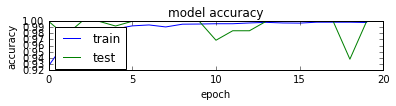

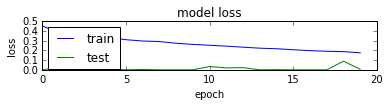

acc: 100.00%
Training and Testing on the OCT Volume no:  24
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_24
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4532 - acc: 0.9181 - val_loss: 1.4389e-07 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3888 - acc: 0.9698 - val_loss: 2.5591e-06 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3717 - acc: 0.9698 - val_loss: 0.0068 - val_acc: 0.9922
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3385 - acc: 0.9864 - val_loss: 0.0056 - val_acc: 0.9922
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3198 - acc: 0.9902 - val_loss: 6.2282e-06 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 87s -

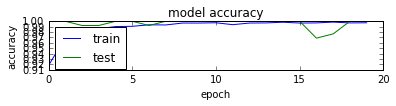

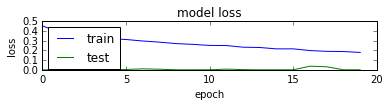

acc: 100.00%
Training and Testing on the OCT Volume no:  25
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_25
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4567 - acc: 0.9151 - val_loss: 1.5739e-07 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3926 - acc: 0.9660 - val_loss: 1.2200e-07 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3626 - acc: 0.9758 - val_loss: 1.4702e-06 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3423 - acc: 0.9849 - val_loss: 0.0289 - val_acc: 0.9766
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3286 - acc: 0.9866 - val_loss: 6.5604e-06 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 8

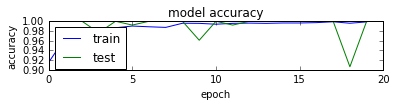

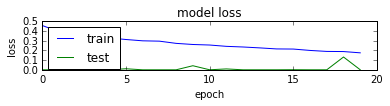

acc: 100.00%
Training and Testing on the OCT Volume no:  26
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_26
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4518 - acc: 0.9221 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3870 - acc: 0.9657 - val_loss: 1.2444e-05 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3650 - acc: 0.9768 - val_loss: 0.0493 - val_acc: 0.9609
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3393 - acc: 0.9816 - val_loss: 0.1181 - val_acc: 0.8828
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3303 - acc: 0.9846 - val_loss: 4.1672e-06 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 87s -

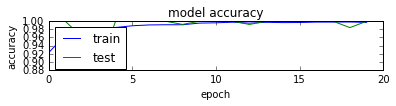

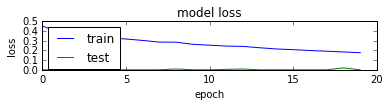

acc: 100.00%
Training and Testing on the OCT Volume no:  27
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_27
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4566 - acc: 0.9196 - val_loss: 1.7928e-07 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3854 - acc: 0.9677 - val_loss: 3.3189e-06 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3622 - acc: 0.9771 - val_loss: 0.0118 - val_acc: 0.9922
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3395 - acc: 0.9879 - val_loss: 3.5356e-04 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3224 - acc: 0.9877 - val_loss: 0.0547 - val_acc: 0.9531
Epoch 6/20
3968/3968 [==============================] - 87s -

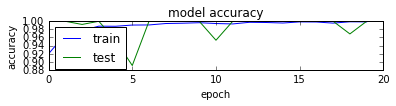

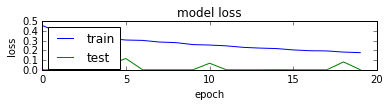

acc: 100.00%
Training and Testing on the OCT Volume no:  28
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_28
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4447 - acc: 0.9246 - val_loss: 5.2876e-04 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3938 - acc: 0.9632 - val_loss: 3.0434e-06 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3737 - acc: 0.9748 - val_loss: 3.0359e-04 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3381 - acc: 0.9861 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3283 - acc: 0.9871 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 8

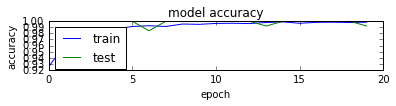

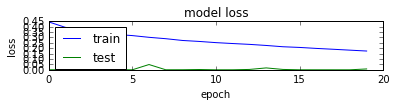

acc: 99.22%
Training and Testing on the OCT Volume no:  29
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_29
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 89s - loss: 0.4426 - acc: 0.9340 - val_loss: 4.5460e-05 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3821 - acc: 0.9758 - val_loss: 2.8095e-04 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3600 - acc: 0.9814 - val_loss: 8.4472e-07 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3385 - acc: 0.9839 - val_loss: 8.4971e-04 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3255 - acc: 0.9899 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 87

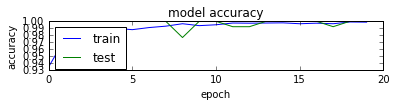

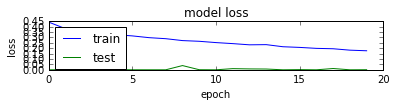

acc: 100.00%
Training and Testing on the OCT Volume no:  30
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_30
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 88s - loss: 0.4473 - acc: 0.9241 - val_loss: 1.0422e-06 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3794 - acc: 0.9708 - val_loss: 2.9927e-04 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3553 - acc: 0.9798 - val_loss: 0.0423 - val_acc: 0.9688
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3579 - acc: 0.9778 - val_loss: 1.2200e-07 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3198 - acc: 0.9894 - val_loss: 3.1644e-05 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================] - 8

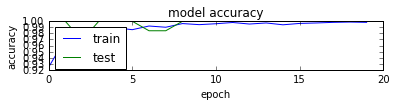

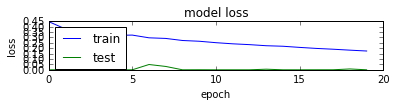

acc: 100.00%
Training and Testing on the OCT Volume no:  31
(3968, 224, 224, 3) (128, 224, 224, 3) (3968, 2) (128, 2)
Dir already existing
New Path created :  ./dataset/Cropped_BM3D/Experiment_InceptionResNetV2/logs_tb/volume_31
Dir already existing
Train on 3968 samples, validate on 128 samples
Epoch 1/20
3968/3968 [==============================] - 88s - loss: 0.4583 - acc: 0.9216 - val_loss: 1.6184e-05 - val_acc: 1.0000
Epoch 2/20
3968/3968 [==============================] - 87s - loss: 0.3817 - acc: 0.9688 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/20
3968/3968 [==============================] - 87s - loss: 0.3578 - acc: 0.9814 - val_loss: 3.9628e-07 - val_acc: 1.0000
Epoch 4/20
3968/3968 [==============================] - 87s - loss: 0.3361 - acc: 0.9844 - val_loss: 4.3757e-04 - val_acc: 1.0000
Epoch 5/20
3968/3968 [==============================] - 87s - loss: 0.3202 - acc: 0.9897 - val_loss: 3.9458e-04 - val_acc: 1.0000
Epoch 6/20
3968/3968 [==============================]

In [15]:
# Train the model for each volume
path = root + '/weight/'
check_dir(path)
path = path + model_name + '_rndm_weight.h5'
#path = '/home/deeplearningutp/PycharmProjects/OCT_Project/dataset/Cropped_BM3D/tmp/weight/InceptionResNetV2_rndm_weight .h5'

cvscores = []
bb = []
k = 0
volume = 1
nohup = 1

no_patients = 32
no_data = 4096
no_train_data = no_data - (no_data / no_patients)
no_test_data = no_data - no_train_data

cv = cross_validation.KFold(no_data, n_folds=no_patients, shuffle=False, random_state=None)

for train_index, test_index in cv:  # remaining
       
    if test_index[0] == k and test_index[0] < k+int(no_test_data):  # take out
        
        print("Training and Testing on the OCT Volume no: ", volume)
        
        pru = []
        aba = []
        
        
        for i in range(0, int(no_train_data)):
            at = input_img[train_index[i]]
            pru.append(at)
        
        pru2 = []
        aba2 = []
        
        for j in range(0, int(no_test_data)):
            at2 = input_img[test_index[j]]
            pru2.append(at2)
        
        
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        y_tr, y_tes = input_labels[train_index[0:int(no_train_data)]], input_labels[test_index[0:int(no_test_data)]]
        print(X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape)
        
        
        # create model
        model.load_weights(path)
        
        
        # Setup checkpoint, log and run the experiment
        CHKPT_PTH = root + '/checkpoint/'
        check_dir(CHKPT_PTH)
        chkpt_pth = CHKPT_PTH + model_name + '_vol_' + str(volume) + '.hdf5'
        
        TB_LOG = root + '/logs_tb/volume_' + str(volume)
        check_dir(TB_LOG)
        
        CSVLOG_PTH = root + '/logs_csv/'
        check_dir(CSVLOG_PTH) 
        CSV_FILENAME = CSVLOG_PTH + 'csv_logger_' + str(volume)
       
        csvlogger = CSVLogger(CSV_FILENAME, 
                              separator=',', 
                              append=False)
        
        checkpointer = ModelCheckpoint(filepath=chkpt_pth,
                                   monitor='val_acc',
                                   verbose=1,
                                   save_best_only=True)
    
        tensorboard = TensorBoard(log_dir=TB_LOG,
                                  histogram_freq=0,
                                  batch_size=batch_size,
                                  write_graph=True,
                                  write_grads=False,
                                  write_images=False,
                                  embeddings_freq=0,
                                  embeddings_layer_names=None,
                                  embeddings_metadata=None)
    
        history = model.fit([X_tr], [y_tr],
                            batch_size=batch_size,
                            nb_epoch=nb_epochs,
                            verbose=1,
                            validation_data=(X_tes, y_tes),
                            callbacks=[checkpointer, tensorboard, csvlogger])
        # loss_history = history_callback.history["loss"]
        
        
        # evaluate the model
        bb1=model.predict([X_tes])
        scores = model.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        print(history.history.keys())
        plt.figure()
        ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4)
        
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        
        # summarize history for loss
        ax2 = plt.subplot2grid((4, 4), (1, 0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
        
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
        
 
        # Next volume / patients
        volume += 1
        k += int(no_test_data)
        
    else:
        
        test_index[0]
        
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
